# Inference Demo for ArcFace models

## Overview
This notebook can be used for inference on ArcFace ONNX models. The demo shows how to use the trained models to do inference in MXNet.

## Models supported
* LResNet100E-IR (ResNet100 backend with ArcFace loss)

## Prerequisites
The following packages need to be installed before proceeding:
* Protobuf compiler - `sudo apt-get install protobuf-compiler libprotoc-dev` (required for ONNX. This will work for any linux system. For detailed installation guidelines head over to [ONNX documentation](https://github.com/onnx/onnx#installation))
* ONNX - `pip install onnx`
* MXNet - `pip install mxnet-cu90mkl --pre -U` (tested on this version GPU, can use other versions. `--pre` indicates a pre build of MXNet which is required here for ONNX version compatibility. `-U` uninstalls any existing MXNet version allowing for a clean install)
* numpy - `pip install numpy`
* matplotlib - `pip install matplotlib`
* OpenCV - `pip install opencv-python`
* Scikit-learn - `pip install scikit-learn`
* EasyDict - `pip install easydict`
* Scikit-image - `pip install scikit-image`

Also the following scripts and folders (included in the repo) must be present in the same folder as this notebook:
* `mtcnn_detector.py` (Performs face detection as a part of preprocessing)
* `helper.py` (helper script for face detection)

In order to do inference with a python script:
* Generate the script : In Jupyter Notebook browser, go to File -> Download as -> Python (.py)
* Run the script: `python arcface_inference.py`

### Import dependencies
Verify that all dependencies are installed using the cell below. Continue if no errors encountered, warnings can be ignored.

In [1]:
!which python

/home/vantuan5644/anaconda3/envs/4S/bin/python


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import cv2
import sys
import numpy as np
import mxnet as mx
import os

from scipy import misc
import random
import sklearn
from sklearn.decomposition import PCA
from time import sleep
from easydict import EasyDict as edict
from skimage import transform as trans
import matplotlib.pyplot as plt
from mxnet.contrib.onnx.onnx2mx.import_model import import_model

In [4]:
import sys, os
sys.path.append(os.path.abspath('..'))

In [5]:
from models.mtcnn_detector import MtcnnDetector


### Load pretrained model
`get_model()` : Loads ONNX model into MXNet symbols and params, defines model using symbol file and binds parameters to the model using params file.

In [6]:
def get_model(ctx, model):
    image_size = (112,112)
    # Import ONNX model
    sym, arg_params, aux_params = import_model(model)
    # Define and binds parameters to the network
    model = mx.mod.Module(symbol=sym, context=ctx, label_names = None)
    model.bind(data_shapes=[('data', (1, 3, image_size[0], image_size[1]))])
    model.set_params(arg_params, aux_params)
    return model

### Face detector & alignment
A pretrained face detection & alignment model [MTCNN detector](https://kpzhang93.github.io/MTCNN_face_detection_alignment/index.html) is used here as a part of the preprocessing step. The input image is passed through the detector to obtain an aligned image of the face in the input. The pretrained models reside in the folder `mtcnn-model` and the scripts `mtcnn_detector.py` and `helper.py` contain code for doing inference on those models.

### Download pre-trained face detection models

In [7]:
mtcnn_weights_path = '../weights/mtcnn-model'

In [8]:
for i in range(4):
    mx.test_utils.download(dirname=mtcnn_weights_path, url='https://s3.amazonaws.com/onnx-model-zoo/arcface/mtcnn-model/det{}-0001.params'.format(i+1))
    mx.test_utils.download(dirname=mtcnn_weights_path, url='https://s3.amazonaws.com/onnx-model-zoo/arcface/mtcnn-model/det{}-symbol.json'.format(i+1))
    mx.test_utils.download(dirname=mtcnn_weights_path, url='https://s3.amazonaws.com/onnx-model-zoo/arcface/mtcnn-model/det{}.caffemodel'.format(i+1))
    mx.test_utils.download(dirname=mtcnn_weights_path, url='https://s3.amazonaws.com/onnx-model-zoo/arcface/mtcnn-model/det{}.prototxt'.format(i+1))

### Configure face detection model for preprocessing

In [9]:
# Determine and set context
if len(mx.test_utils.list_gpus())==0:
    ctx = mx.cpu()
else:
    ctx = mx.gpu(0)
# Configure face detector
det_threshold = [0.6,0.7,0.8]
model_folder = os.path.abspath(mtcnn_weights_path)
detector = MtcnnDetector(model_folder=model_folder, ctx=ctx, num_worker=1, accurate_landmark = True, threshold=det_threshold)

### Preprocess images

In order to input only face pixels into the network, all input images are passed through a pretrained face detection and alignment model as described above. The output of this model are landmark points and a bounding box corresponding to the face in the image. Using this output, the image is processed using affine transforms to generate the aligned face images which are input to the network. The functions performing this is defined below.

`preprocess()` : Takes output of face detector (bounding box and landmark points for face in the image) as input and generates aligned face images

`get_input()` : Passes input images through the face detector, and returns aligned face images generated by `preprocess()`

In [10]:
def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = []
    str_image_size = kwargs.get('image_size', '')
    # Assert input shape
    if len(str_image_size)>0:
        image_size = [int(x) for x in str_image_size.split(',')]
        if len(image_size)==1:
            image_size = [image_size[0], image_size[0]]
        assert len(image_size)==2
        assert image_size[0]==112
        assert image_size[0]==112 or image_size[1]==96
    
    # Do alignment using landmark points
    if landmark is not None:
        assert len(image_size)==2
        src = np.array([
          [30.2946, 51.6963],
          [65.5318, 51.5014],
          [48.0252, 71.7366],
          [33.5493, 92.3655],
          [62.7299, 92.2041] ], dtype=np.float32 )
        if image_size[1]==112:
            src[:,0] += 8.0
        dst = landmark.astype(np.float32)
        tform = trans.SimilarityTransform()
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped
    
    # If no landmark points available, do alignment using bounding box. If no bounding box available use center crop
    if M is None:
        if bbox is None:
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
            det = bbox
        margin = kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin/2, 0)
        bb[1] = np.maximum(det[1]-margin/2, 0)
        bb[2] = np.minimum(det[2]+margin/2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin/2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
            ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret
    
def get_input(detector,face_img):
    # Pass input images through face detector
    ret = detector.detect_face(face_img, det_type = 0)
    if ret is None:
        return None
    bbox, points = ret
    if bbox.shape[0]==0:
        return None
    bbox = bbox[0,0:4]
    points = points[0,:].reshape((2,5)).T
    # Call preprocess() to generate aligned images
    nimg = preprocess(face_img, bbox, points, image_size='112,112')
    nimg = cv2.cvtColor(nimg, cv2.COLOR_BGR2RGB)
    aligned = np.transpose(nimg, (2,0,1))
    return aligned

### Predict
`get_feature()` : Performs forward pass on the data `aligned` using `model` and returns the embedding

In [11]:
def get_feature(model,aligned):
    input_blob = np.expand_dims(aligned, axis=0)
    data = mx.nd.array(input_blob)
    db = mx.io.DataBatch(data=(data,))
    model.forward(db, is_train=False)
    embedding = model.get_outputs()[0].asnumpy()
    embedding = sklearn.preprocessing.normalize(embedding).flatten()
    return embedding

### Download input images and prepare ONNX model

In [15]:
# Download first image
mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/arcface/player1.jpg')
# Download second image
mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/arcface/player2.jpg')
# Download onnx model
mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/arcface/resnet100.onnx',
                      dirname='../weights/arcface')
# Path to ONNX model
model_name = '../weights/arcface/resnet100.onnx'

In [16]:
# Load ONNX model
model = get_model(ctx , model_name)

### Generate predictions
Two face images are passed through the network sequentially to generate embedding vectors for each. The squared distance and cosine similarity between the embedding vectors are computed and displayed. Images containing face of a single person will have low distance and high similarity and vice-versa. The distance values are in [0,4) and similarity values in [-1,1].

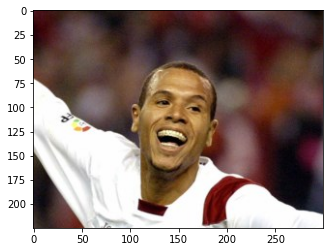

In [17]:
# Load first image
img1 = cv2.imread('player1.jpg')
# Display first image
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

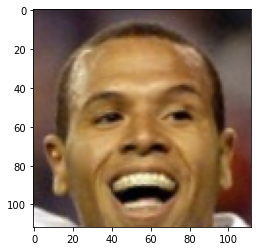

In [18]:
import time
start = time.time()
# Preprocess first image
pre1 = get_input(detector,img1)
print(f"MTCNN run in {time.time() - start}")
# Display preprocessed image
plt.imshow(np.transpose(pre1,(1,2,0)))
plt.show()
# Get embedding of first image

start = time.time()
out1 = get_feature(model,pre1)
print(f"Arcface run in {time.time() - start}")

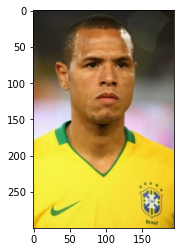

In [19]:
# Load second image
img2 = cv2.imread('player2.jpg')
# Display second image
plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
plt.show()

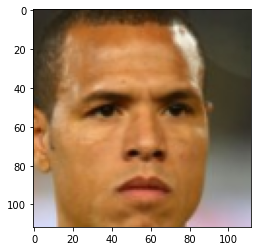

In [20]:
# Preprocess second image
pre2 = get_input(detector,img2)
# Display preprocessed image
plt.imshow(np.transpose(pre2,(1,2,0)))
plt.show()
# Get embedding of second image
out2 = get_feature(model,pre2)

In [21]:
# Compute squared distance between embeddings
dist = np.sum(np.square(out1-out2))
# Compute cosine similarity between embedddings
sim = np.dot(out1, out2.T)
# Print predictions
print('Distance = %f' %(dist))
print('Similarity = %f' %(sim))

Distance = 0.461761
Similarity = 0.769119
